Training samples: 8143
Test samples:     9752
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Single-layer (1 units) test accuracy: 0.9800
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Single-layer (5 units) test accuracy: 0.9355
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Single-layer (10 units) test accuracy: 0.8852
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Single-layer (20 units) test accuracy: 0.9533
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Single-layer (50 units) test accuracy: 0.9158


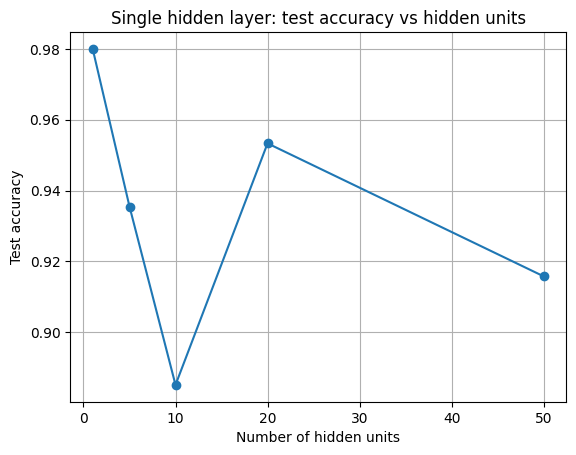

305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Two-layer 5-5 test accuracy: 0.9011
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Two-layer 10-5 test accuracy: 0.8904
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Two-layer 20-10 test accuracy: 0.9670
Single layer results:
|   hidden_units |   test_accuracy |
|---------------:|----------------:|
|              1 |        0.980004 |
|              5 |        0.9355   |
|             10 |        0.885152 |
|             20 |        0.953343 |
|             50 |        0.915812 |

Two-layer results:
| architecture   |   test_accuracy |
|:---------------|----------------:|
| 5-5            |        0.901148 |
| 10-5           |        0.890381 |
| 20-10          |        0.966981 |

Experiment complete. The summary tables have been displayed.


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings("ignore")

train_path = "trainData.txt"
test_path = "testData.txt"

# Load CSVs: the uploaded files use quotes and header; try robust read
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Show basic info
n_train = train.shape[0]
n_test = test.shape[0]

print(f"Training samples: {n_train}")
print(f"Test samples:     {n_test}")

# Drop the 'date' column if present and any unnamed index columns
for df in (train, test):
    if "date" in df.columns:
        df.drop(columns=["date"], inplace=True)
    # sometimes first column is an unnamed index; drop if present and non-informative
    unnamed = [c for c in df.columns if c.lower().startswith("unnamed")]
    if unnamed:
        df.drop(columns=unnamed, inplace=True)

# Features and label
feature_cols = ["Temperature","Humidity","Light","CO2","HumidityRatio"]
label_col = "Occupancy"

X_train = train[feature_cols].values
y_train = train[label_col].values.astype(int)
X_test = test[feature_cols].values
y_test = test[label_col].values.astype(int)

# Standardize features (fit on train only)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Try to import tensorflow, otherwise fall back to sklearn MLP
#use_tf = False
# try:
#     import tensorflow as tf
#     from tensorflow.keras import Sequential
#     from tensorflow.keras.layers import Dense
#     from tensorflow.keras.optimizers import Adam
#     use_tf = True
#     print("TensorFlow is available and will be used for training.\n")
# except Exception as e:
#     print("TensorFlow not available in this environment. Falling back to sklearn MLPClassifier.\n")
#     from sklearn.neural_network import MLPClassifier

# Utility functions for training and evaluation
def train_eval_tf(hidden_layers, Xtr, ytr, Xte, yte, epochs=30, batch_size=32, verbose=0):
    # hidden_layers: list of ints
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation="relu", input_shape=(Xtr.shape[1],)))
    for units in hidden_layers[1:]:
        model.add(Dense(units, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(Xtr, ytr, epochs=epochs, batch_size=batch_size, verbose=verbose)
    preds = (model.predict(Xte) > 0.5).astype(int).ravel()
    acc = accuracy_score(yte, preds)
    return acc

def train_eval_sklearn(hidden_layers, Xtr, ytr, Xte, yte, max_iter=200):
    # hidden_layers: list of ints
    clf = MLPClassifier(hidden_layer_sizes=tuple(hidden_layers), activation="relu", solver="adam", max_iter=max_iter, random_state=42)
    clf.fit(Xtr, ytr)
    preds = clf.predict(Xte)
    acc = accuracy_score(yte, preds)
    return acc

# (b) Vary number of hidden units in single hidden layer
units_list = [1, 5, 10, 20, 50]
single_layer_results = {}
for u in units_list:
    if use_tf:
        acc = train_eval_tf([u], X_train_s, y_train, X_test_s, y_test, epochs=40, batch_size=32, verbose=0)
    else:
        acc = train_eval_sklearn([u], X_train_s, y_train, X_test_s, y_test, max_iter=400)
    single_layer_results[u] = acc
    print(f"Single-layer ({u} units) test accuracy: {acc:.4f}")

# Plot results for (b)
plt.figure()
plt.plot(list(single_layer_results.keys()), list(single_layer_results.values()), marker='o')
plt.title("Single hidden layer: test accuracy vs hidden units")
plt.xlabel("Number of hidden units")
plt.ylabel("Test accuracy")
plt.grid(True)
plt.show()

# (c) Three architectures with 2 hidden layers
architectures = {
    "5-5": [5,5],
    "10-5": [10,5],
    "20-10": [20,10]
}
two_layer_results = {}
for name, arch in architectures.items():
    if use_tf:
        acc = train_eval_tf(arch, X_train_s, y_train, X_test_s, y_test, epochs=40, batch_size=32, verbose=0)
    else:
        acc = train_eval_sklearn(arch, X_train_s, y_train, X_test_s, y_test, max_iter=400)
    two_layer_results[name] = acc
    print(f"Two-layer {name} test accuracy: {acc:.4f}")

# Summaries as a dataframe
summary_single = pd.DataFrame({"hidden_units": list(single_layer_results.keys()), "test_accuracy": list(single_layer_results.values())})
summary_two = pd.DataFrame({"architecture": list(two_layer_results.keys()), "test_accuracy": list(two_layer_results.values())})

print("Single layer results:")
print(summary_single.to_markdown(index=False))
print("\nTwo-layer results:")
print(summary_two.to_markdown(index=False))

print("\nExperiment complete. The summary tables have been displayed.")

Single-layer (1 units) test accuracy: 0.7899
Single-layer (5 units) test accuracy: 0.9159
Single-layer (10 units) test accuracy: 0.9297
Single-layer (20 units) test accuracy: 0.9393
Single-layer (50 units) test accuracy: 0.8928


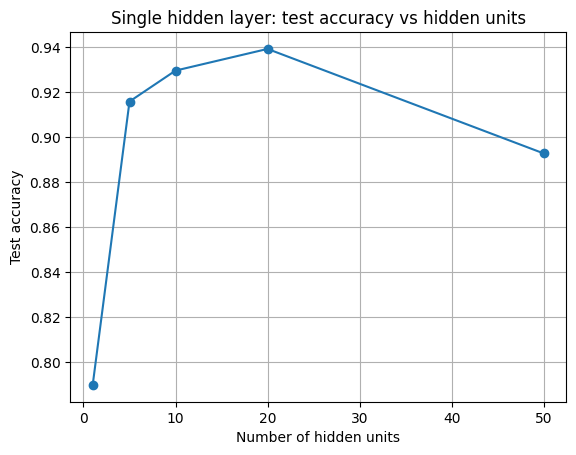

Two-layer 5-5 test accuracy: 0.9340
Two-layer 10-5 test accuracy: 0.9201
Two-layer 20-10 test accuracy: 0.9139
Single layer results (fast):
|   hidden_units |   test_accuracy |
|---------------:|----------------:|
|              1 |        0.789889 |
|              5 |        0.915915 |
|             10 |        0.929655 |
|             20 |        0.939295 |
|             50 |        0.892842 |
Two-layer results (fast):
| architecture   |   test_accuracy |
|:---------------|----------------:|
| 5-5            |        0.933962 |
| 10-5           |        0.920119 |
| 20-10          |        0.913864 |
Done.


In [ ]:
# Rerun experiments with faster settings to finish within time.
# Use sklearn MLP with smaller max_iter to ensure quick completion.
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

train = pd.read_csv("trainData.txt")
test = pd.read_csv("testData.txt")
for df in (train, test):
    if "date" in df.columns:
        df.drop(columns=["date"], inplace=True)
    unnamed = [c for c in df.columns if c.lower().startswith("unnamed")]
    if unnamed:
        df.drop(columns=unnamed, inplace=True)

feature_cols = ["Temperature","Humidity","Light","CO2","HumidityRatio"]
label_col = "Occupancy"
X_train = train[feature_cols].values; y_train = train[label_col].values.astype(int)
X_test = test[feature_cols].values; y_test = test[label_col].values.astype(int)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train); X_test_s = scaler.transform(X_test)

def train_eval_sklearn_fast(hidden_layers, Xtr, ytr, Xte, yte, max_iter=200):
    clf = MLPClassifier(hidden_layer_sizes=tuple(hidden_layers), activation="relu", solver="adam", max_iter=max_iter, random_state=42)
    clf.fit(Xtr, ytr)
    preds = clf.predict(Xte)
    return accuracy_score(yte, preds)

units_list = [1,5,10,20,50]
single_layer_results = {}
for u in units_list:
    acc = train_eval_sklearn_fast([u], X_train_s, y_train, X_test_s, y_test, max_iter=200)
    single_layer_results[u] = acc
    print(f"Single-layer ({u} units) test accuracy: {acc:.4f}")

plt.figure()
plt.plot(list(single_layer_results.keys()), list(single_layer_results.values()), marker='o')
plt.title("Single hidden layer: test accuracy vs hidden units")
plt.xlabel("Number of hidden units")
plt.ylabel("Test accuracy")
plt.grid(True)
plt.show()

architectures = {"5-5":[5,5],"10-5":[10,5],"20-10":[20,10]}
two_layer_results = {}
for name, arch in architectures.items():
    acc = train_eval_sklearn_fast(arch, X_train_s, y_train, X_test_s, y_test, max_iter=200)
    two_layer_results[name] = acc
    print(f"Two-layer {name} test accuracy: {acc:.4f}")

summary_single = pd.DataFrame({"hidden_units": list(single_layer_results.keys()), "test_accuracy": list(single_layer_results.values())})
summary_two = pd.DataFrame({"architecture": list(two_layer_results.keys()), "test_accuracy": list(two_layer_results.values())})
print("Single layer results (fast):")
print(summary_single.to_markdown(index=False))
print("Two-layer results (fast):")
print(summary_two.to_markdown(index=False))
print("Done.")

Training samples: 8143
Test samples:     9752
Using TensorFlow Keras for models.
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Single-layer 1 units -> test acc: 0.9917
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Single-layer 5 units -> test acc: 0.9296
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Single-layer 10 units -> test acc: 0.9224
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Single-layer 20 units -> test acc: 0.9395
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Single-layer 50 units -> test acc: 0.9026


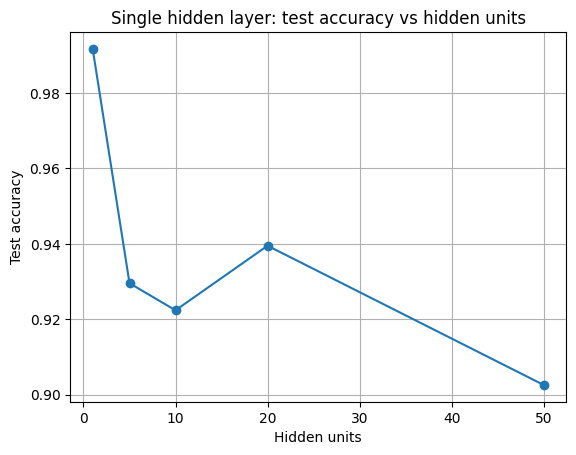

305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
5-5 -> test acc: 0.9893
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
10-5 -> test acc: 0.9381
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
20-10 -> test acc: 0.9071


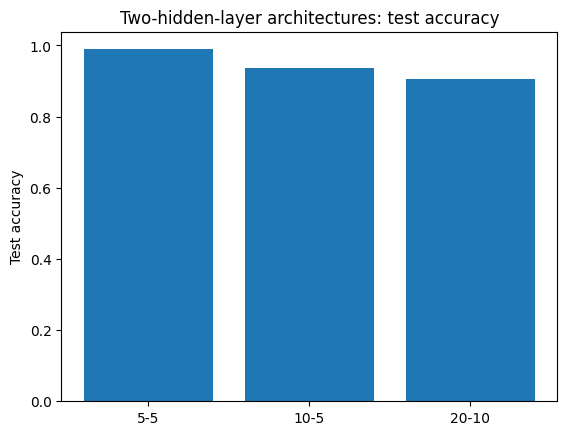

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Paths (change if needed)
TRAIN_PATH = "trainData.txt"
TEST_PATH  = "testData.txt"

# Load
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

# Drop 'date' and any unnamed index columns
for df in (train, test):
    if "date" in df.columns:
        df.drop(columns=["date"], inplace=True)
    unnamed = [c for c in df.columns if c.lower().startswith("unnamed")]
    if unnamed:
        df.drop(columns=unnamed, inplace=True)

print("Training samples:", train.shape[0])
print("Test samples:    ", test.shape[0])

# Features / label
features = ["Temperature","Humidity","Light","CO2","HumidityRatio"]
label = "Occupancy"
X_train = train[features].values
y_train = train[label].astype(int).values
X_test  = test[features].values
y_test  = test[label].astype(int).values

# Standardize
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# Try TensorFlow Keras; if not available, fallback to sklearn MLP
use_tf = False
try:
    import tensorflow as tf
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.optimizers import Adam
    use_tf = True
    print("Using TensorFlow Keras for models.")
except Exception:
    print("TensorFlow not found. Falling back to sklearn MLP.")

from sklearn.neural_network import MLPClassifier

def train_eval_tf(hidden_layers, Xtr, ytr, Xte, yte, epochs=40, batch_size=32, verbose=0):
    model = Sequential()
    model.add(Dense(hidden_layers[0], activation="relu", input_shape=(Xtr.shape[1],)))
    for h in hidden_layers[1:]:
        model.add(Dense(h, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(0.01), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(Xtr, ytr, epochs=epochs, batch_size=batch_size, verbose=verbose)
    preds = (model.predict(Xte) > 0.5).astype(int).ravel()
    return accuracy_score(yte, preds)

def train_eval_sklearn(hidden_layers, Xtr, ytr, Xte, yte, max_iter=300):
    clf = MLPClassifier(hidden_layer_sizes=tuple(hidden_layers), activation="relu", solver="adam",
                        max_iter=max_iter, random_state=42)
    clf.fit(Xtr, ytr)
    preds = clf.predict(Xte)
    return accuracy_score(yte, preds)

# (b) Sweep single hidden-layer sizes
units_list = [1, 5, 10, 20, 50]
single_results = {}
for u in units_list:
    if use_tf:
        acc = train_eval_tf([u], X_train_s, y_train, X_test_s, y_test, epochs=40, batch_size=32)
    else:
        acc = train_eval_sklearn([u], X_train_s, y_train, X_test_s, y_test, max_iter=400)
    single_results[u] = acc
    print(f"Single-layer {u} units -> test acc: {acc:.4f}")

# Plot single-layer sweep
plt.figure()
plt.plot(list(single_results.keys()), list(single_results.values()), marker='o')
plt.title("Single hidden layer: test accuracy vs hidden units")
plt.xlabel("Hidden units")
plt.ylabel("Test accuracy")
plt.grid(True)
plt.show()

# (c) three architectures with 2 hidden layers
architectures = {"5-5":[5,5], "10-5":[10,5], "20-10":[20,10]}
two_layer_results = {}
for name, arch in architectures.items():
    if use_tf:
        acc = train_eval_tf(arch, X_train_s, y_train, X_test_s, y_test, epochs=40, batch_size=32)
    else:
        acc = train_eval_sklearn(arch, X_train_s, y_train, X_test_s, y_test, max_iter=400)
    two_layer_results[name] = acc
    print(f"{name} -> test acc: {acc:.4f}")

# Plot two-layer results
plt.figure()
plt.bar(list(two_layer_results.keys()), list(two_layer_results.values()))
plt.title("Two-hidden-layer architectures: test accuracy")
plt.ylabel("Test accuracy")
plt.show()